In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import intervals

In [2]:
hep.set_style(hep.styles.CMS)

In [ ]:
NUM_CHAMBERS = 36 # consider only GE11 for now

In [ ]:
class Efficiency:
    def __init__(self, num, denom, confidence_level=0.683
    ) -> None:
        self.nominal_value = num / denom
    
        self.lower_bound, self.upper_bound = intervals.clopper_pearson_interval(
            num=num,
            denom=denom,
            coverage=confidence_level)
        
        self.lower_error = self.nominal_value - self.lower_bound
        self.upper_error = self.upper_bound - self.nominal_value

    @property
    def x(self):
        r"""
        `index` corresponds to chamber numbers
        """
        return self.nominal_value.index
    
    @property
    def error(self):
        return [self.lower_error, self.upper_error]

$$
\huge \epsilon\left(\text{chamber}\right) = \frac{ \sum_{\text{run}} N_{ \text{matched} } \left(\text{run}, \text{chamber} \right) }{ \sum_{\text{run}} N_{ \text{propagations} } \left(\text{run}, \text{chamber} \right) }
$$

In [ ]:
def plot_efficiency(data, label, color, ax=None):
    if ax is None:
        ax = plt.gca()

    gby = data.groupby('chamber')
    passed = gby.passed.sum()
    total = gby.total.sum()

    eff = Efficiency(passed, total, confidence_level=0.683)

    x = np.arange(1, NUM_CHAMBERS + 1)
    allowed_chambers = data.chamber.unique()

    def insert_pad(y):
        r"""
        Some chambers may be missing. Then, if pads are not inserted into y,
        matplotlib performs the interpolation.
        """
        return np.array([y.loc[chamber] if chamber in allowed_chambers else np.nan for chamber in x])

    ylow = insert_pad(gby.eff.min())
    yup = insert_pad(gby.eff.max())

    where = np.logical_not(np.isnan(ylow))

    # band
    ax.fill_between(x, ylow, yup, where=where, color=color, label=label, alpha=0.2)
    
    # lower and upper
    ax.plot(x, ylow, alpha=0.5, color=color, ls='-', lw=3)
    ax.plot(x, yup, alpha=0.5, color=color, ls='-', lw=3)

    # the overall efficiency
    ax.errorbar(eff.x, eff.nominal_value, eff.error, color=color, marker="s",
                ls="", capsize=10, capthick=2)

In [6]:
data_path = Path("./data/Cosmics.csv")
df = pd.read_csv(data_path)
print(f"# of chambers: {len(df)}")

# Remove bad chambers
is_good = (df.online_report == 1) & df.has_dc & df.is_good
df = df[is_good]
print(f"# of chambers: {len(df)}")


# Apply more cuts
min_propagations = 100
df = df[df.total >= min_propagations]
print(f"# of chambers: {len(df)}")

# of chambers: 3168
# of chambers: 1425
# of chambers: 1219


In [7]:
hv_color_list = [
    (690, "tab:blue"),
    (680, "tab:orange"),
]

plot_dir = Path("./plots") 

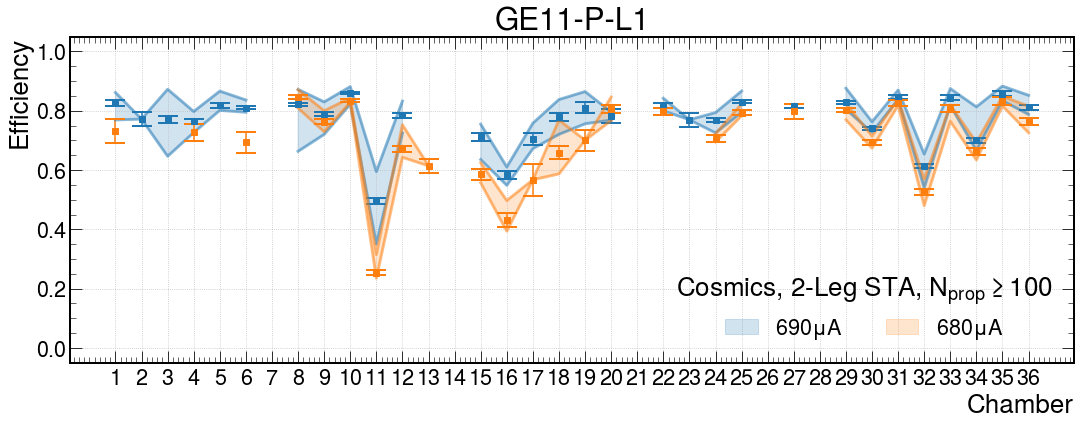

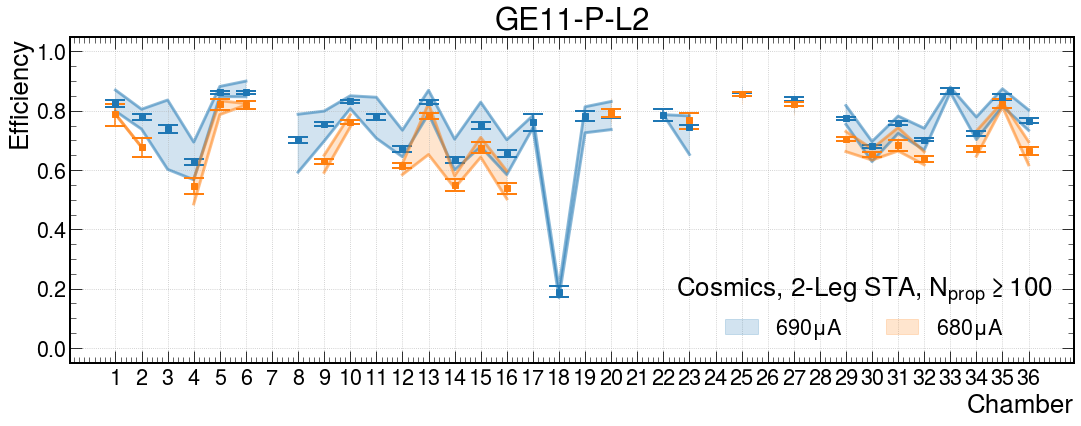

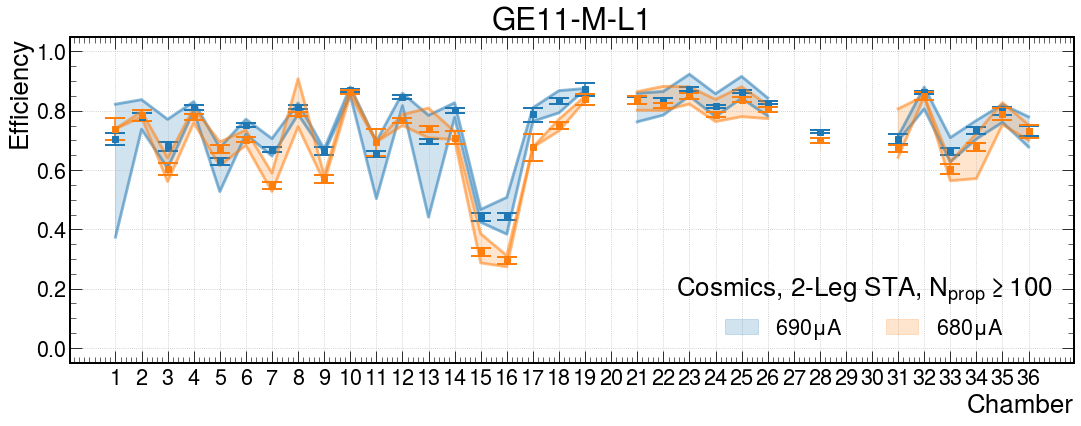

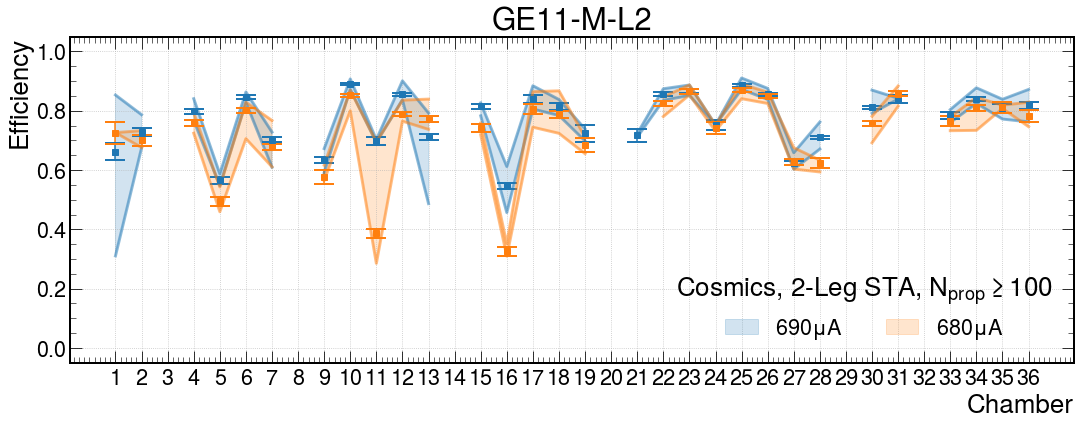

In [8]:
for region in [1, -1]:
    for layer in [1, 2]:
        fig, ax = plt.subplots(figsize=(18, 6), nrows=1)

        data = df[(df.region == region) & (df.layer == layer)]

        for hv, color in hv_color_list:
            plot_efficiency(data[data.hv == hv], label=f"{hv}$\mu$A", color=color, ax=ax)

        _ = ax.set_xticks(range(1, NUM_CHAMBERS + 1))

        title = f"GE11-{'P' if region > 0 else 'M'}-L{layer}"
        ax.set_title(title)
        
        ax.set_xlabel("Chamber")
        ax.set_ylabel("Efficiency")

        legend_title = f"{data_path.stem}, 2-Leg STA, $N_{{prop}} \geq ${min_propagations}"
        ax.legend(title=legend_title, ncol=2, loc='lower right')

        ax.grid()
        ax.set_ylim(-0.05, 1.05)
        
        plot_name = f"{data_path.stem}_{title}_NumPropCut-{min_propagations}"
        plot_path = plot_dir.joinpath(plot_name).with_suffix(".png")

        fig.savefig(plot_path, bbox_inches="tight")